In [457]:
import numpy as np
import networkx as nx
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ndlib.models import DiffusionModel
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.dynamic as dm
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments.NodeStochastic as ns
import dynetx as dn

from typing import Union, List, Dict, Tuple, Optional
from pprint import pprint
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

In [205]:
%matplotlib inline

five hallmarks of stochastic SIR dynamics: variability; negative
co-variances; increased transients; stochastic resonance; and extinctions

Design a set of well chosen experiments to demonstrate all these aspects,also exploring the dependence on the basic parameters in the model.

In [398]:
class SIR_Demographic:
    def __init__(self, beta, gamma, mu=0.0, epsilon=0.0, i0=0.05, N_pop=1000):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
        self.i0 = i0
        self.N_pop = N_pop
    
    def simulate(self, t_end=200):
        t = [0]
        I = [int(self.i0 * self.N_pop)]
        S = [self.N_pop - I[0]]
        R = [0]
        
        while t[-1] < float(t_end):
            N = S[-1] + I[-1] + R[-1]
            N = np.max([0.0001, N]) # avoid zero
            events = {
                "birth": self.mu * N,
                "transmission": self.beta * S[-1] * I[-1] / N,
                "recovery": self.gamma * I[-1],
                "death_susceptible": self.mu * S[-1],
                "death_infected": self.mu * I[-1],
                "death_recovered": self.mu * R[-1],
                # "import": self.epsilon * N,
                "import": self.epsilon * S[-1],
            }
            events = {event: rate for event, rate in events.items() if rate > 0}
            if len(events) < 1:
                break
                
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            
            # compute arrival times for each
            event_time = {
                event: -1.0/rate * np.log(np.random.uniform(0, 1))
                for event, rate in events.items()
            }
            
            # choose event that will occur next
            event, arrival = sorted(event_time.items(), key=lambda x: x[1])[0]
            
            if event == "birth":
                S[-1] += 1
            elif event == "transmission":
                S[-1] -= 1
                I[-1] += 1
            elif event == "recovery":
                I[-1] -= 1
                R[-1] += 1
            elif event == "death_susceptible":
                S[-1] -= 1
            elif event == "death_infected":
                I[-1] -= 1
            elif event == "death_recovered":
                R[-1] -= 1
            elif event == "import":
                S[-1] -= 1
                I[-1] += 1
            
            t.append(t[-1] + arrival)
        
        t = np.array(t)
        tt = np.linspace(0, t_end, t_end)
        Sip = interp1d(t, np.array(S), fill_value="extrapolate")
        Iip = interp1d(t, np.array(I), fill_value="extrapolate")
        Rip = interp1d(t, np.array(R), fill_value="extrapolate")
        result = np.array([Sip(tt), Iip(tt), Rip(tt)])
        return t, tt, result.T

In [383]:
def simulate_sir(
    beta=0.001, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.05,
    N_pop=1000, t_end=200, repetitions=1,
):
    config = dict(
        beta=beta, gamma=gamma, mu=mu, epsilon=epsilon, i0=i0, N_pop=N_pop
    )
    model = SIR_Demographic(**config)
    ts, results = [], []
    for r in range(repetitions):
        _, t, result = model.simulate(t_end)
        ts.append(t)
        results.append(result)
        
    ts = np.vstack(ts).reshape(repetitions, t_end)
    results = np.vstack(results).reshape(repetitions, t_end, 3)
    return ts, results

In [573]:
colors = {
    "susceptible": "blue",
    "infected": "red",
    "recovered": "green",
}

def config_str(config, exclude=None):
    exclude = exclude or []
    s = []
    conf = {k:v for k,v in config.items() if k not in exclude}
    if "beta" in conf:
        s.append("$\\beta=%.2f$" % conf["beta"])
    if "gamma" in conf:
        s.append("$\gamma=%.2f$" % conf["gamma"])
    if "mu" in conf:
        s.append("$\mu=%.2f$" % conf["mu"])
    if "epsilon" in conf:
        s.append("$\epsilon=%.2f$" % conf["epsilon"])
    if "i0" in conf:
        s.append("$I_0=%.2f$" % conf["i0"])
    if "N_pop" in conf:
        s.append("$N_{pop}=%d$" % conf["N_pop"])
    return ", ".join(s)

def _plot_sir(
    results,
    config,
    confidence=True,
    confidence_scale=1.0,
    confidence_alpha=0.3,
):
    fig, ax = plt.subplots()
    for label, (t, result, options) in results.items():
        default_options = dict(
            label=label,
            color=colors.get(label.lower(), "blue"),
        )
        options = {**default_options, **options}
        mean = result.mean(axis=0)
        ax.plot(t, mean, **options)
        if confidence and result.shape[0] > 1:
            std = result.std(axis=0)
            ax.fill_between(
                t,
                mean - std*confidence_scale,
                mean + std*confidence_scale,
                alpha=confidence_alpha,
                color=options.get("color"),
            )
    plt.ylabel("population")
    plt.xlabel("time $t$")
    plt.title((
        "SIR using Gillespie’s discrete event model (%s)" % config_str(config)
    ))
    plt.legend()
    plt.tight_layout()
    return fig, ax

def plot_sir(
    t,
    results,
    config,
    confidence=True,
    confidence_scale=1.0,
    confidence_alpha=0.3,
):
    t = t.mean(axis=0)
    return _plot_sir({
            "Susceptible": (t, results[:,:,0], {}),
            "Infected": (t, results[:,:,1], {}),
            "Recovered":(t, results[:,:,2], {}),
        },
        config=config,
        confidence=confidence,
        confidence_scale=confidence_scale,
        confidence_alpha=confidence_alpha,
    )

#### Variability between simulations
- It is generally impossible to predetermine the precise disease prevalence at any given point in the future.

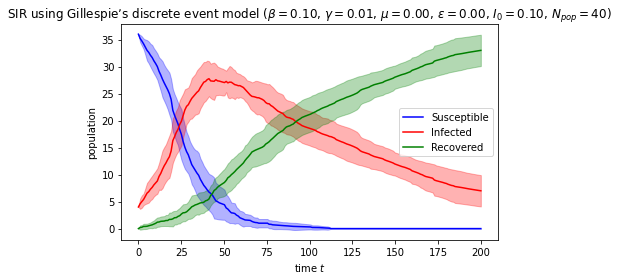

In [365]:
config = dict(
    beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, N_pop=40, repetitions=10
)
t, results = simulate_sir(**config)
fig, ax = plot_sir(t, results, config=config)
plt.show()

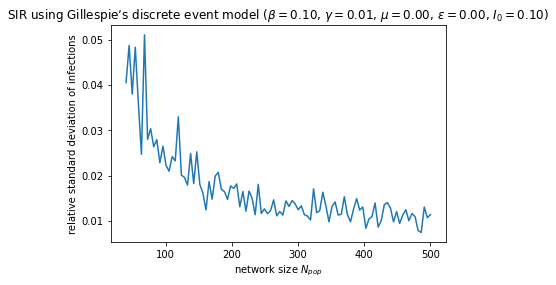

In [366]:
network_sizes = np.linspace(40,500,1_00)
per_network_size_results = []
for size in network_sizes:
    config = dict(
        beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, repetitions=10
    )
    t, results = simulate_sir(N_pop=size, **config)
    mean_std = (results[:,:,0] / size).std(axis=0).mean()
    per_network_size_results.append(mean_std)
    
per_network_size_results = np.array(per_network_size_results)
fig, ax = plt.subplots()
ax.plot(network_sizes, per_network_size_results)
plt.ylabel("relative standard deviation of infections")
plt.xlabel("network size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model (%s)" % config_str(config)
))
plt.show()

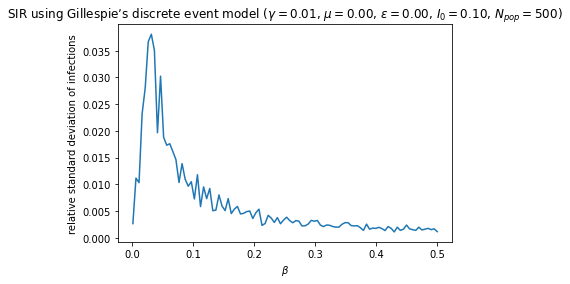

In [367]:
betas = np.linspace(0.001,0.5,100)
per_beta_results = []
for beta in betas:
    config = dict(
        gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, N_pop=500, repetitions=10
    )
    t, results = simulate_sir(beta=beta, **config)
    mean_std = (results[:,:,0] / size).std(axis=0).mean()
    per_beta_results.append(mean_std)
    
per_beta_results = np.array(per_beta_results)
fig, ax = plt.subplots()
ax.plot(betas, per_beta_results)
plt.ylabel("relative standard deviation of infections")
plt.xlabel("$\\beta$")
plt.title((
    "SIR using Gillespie’s discrete event model (%s)" % config_str(config)
))
plt.show()

#### Variances and covariance
- Stochastic processes lead to variance in the prevalence of disease.
- Interaction between stochasticity and underlying deterministic nonlinear dynamics leads to negative covariance between number of susceptibles and infectious.
- And because of that, the mean population level $X,Y$ deviate from the deterministic equilibria.


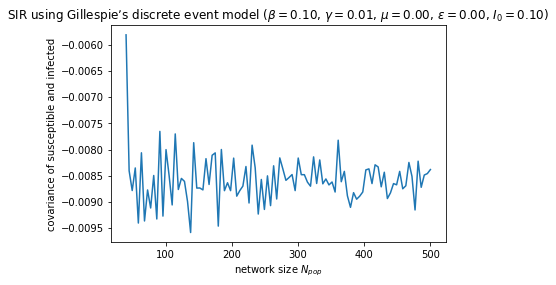

In [368]:
# negative covariance between number of infected and susceptible
network_sizes = np.linspace(40,500,1_00)
cov_per_network_size = []
for size in network_sizes:
    config = dict(
        beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, repetitions=100
    )
    t, results = simulate_sir(N_pop=size, **config)
    results = np.array(results).mean(axis=0) / size
    cov = np.cov(results[:,0], results[:,1]) # s wrt i
    cov_per_network_size.append(cov)
    
cov_per_network_size = np.array(cov_per_network_size)
fig, ax = plt.subplots()
ax.plot(network_sizes, cov_per_network_size[:,0,1])
plt.ylabel("covariance of susceptible and infected")
plt.xlabel("network size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model (%s)" % config_str(config)
))
plt.show()

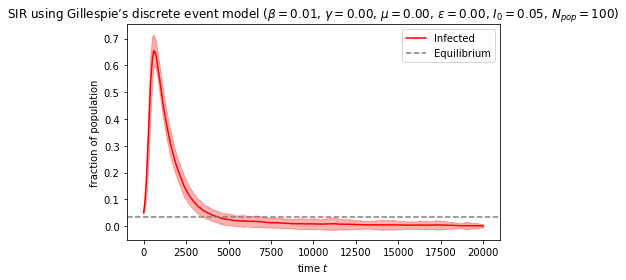

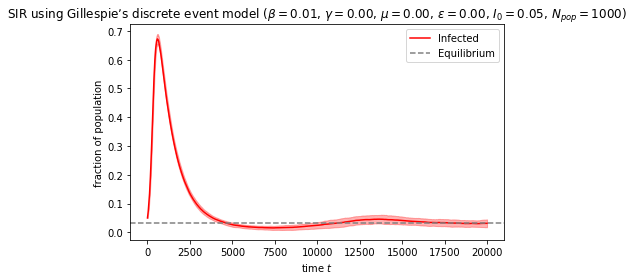

In [369]:
for pop_size in [100, 1000]:
    config = dict(
        beta=0.01, gamma=0.001, mu=1/(70 * 365), epsilon=0.0, i0=0.05,
        N_pop=pop_size, repetitions=100, t_end=20_000
    )
    R_0 = config["beta"] / (config["mu"] + config["gamma"])
    I_equilibrium = config["mu"] / config["beta"] * (R_0 - 1.0)
    t, results = simulate_sir(**config)
    fig, ax = _plot_sir({
        "Infected": (t.mean(axis=0), results[:,:,1] / pop_size)
    }, config=config)
    ax.axhline(y=I_equilibrium, color='gray', label="Equilibrium", linestyle='--')
    plt.ylabel("fraction of population")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Increased transients
- Stochastic perturbations away from the endemic equilibrium are countered by the restorive forces of the endemic attractor, leading to transient like returns to the endemic equilibrium


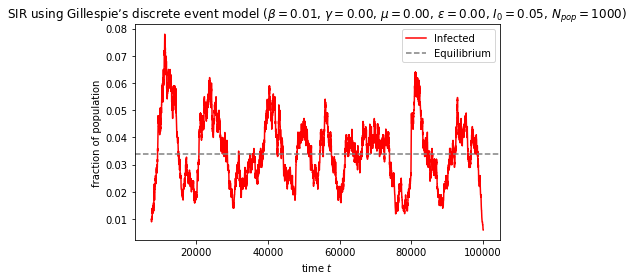

In [389]:
config = dict(
    beta=0.01, gamma=0.001, mu=1/(70 * 365), epsilon=0.0, i0=0.05,
    N_pop=1000, repetitions=1, t_end=100_000
)
R_0 = config["beta"] / (config["mu"] + config["gamma"])
I_equilibrium = config["mu"] / config["beta"] * (R_0 - 1.0)
t, results = simulate_sir(**config)
start = 7500
fig, ax = _plot_sir({
    "Infected": (t.mean(axis=0)[start:], results[:,start:,1] / config["N_pop"])
}, config=config)
ax.axhline(y=I_equilibrium, color='gray', label="Equilibrium", linestyle='--')
plt.ylabel("fraction of population")
plt.legend()
plt.tight_layout()
plt.show()

#### Stochastic Resonance
- Stochastic perturbations can excite oscillations close to the natural frequency of the deterministic SIR dynamics. So, stochasticity can excite epidemic oscillations around the endemic state.


#### Extinctions
- For integer-valued stochastic models, stochasticity can lead to extinctions (that is, the number of infectious individuals goes to zero due to fluctuations), even when $R_0 > 1$.
- In closed populations, chance fluctuations will always in the long run lead to extinction of the disease.
- Long term persistence only possible via import of the pathogen
- Similar extinctions may occur during the early stage of invasion.

In [406]:
beta = 10 * (5.5*10e-5 + 1/10)
network_sizes = np.linspace(100,100_000,20)
time_extinct_per_population_size = []
config = dict(
    beta=beta, gamma=1/10, mu=5.5*10e-5, i0=0.05,
    repetitions=50, t_end=5 * 365
)
R_0 = config["beta"] / (config["mu"] + config["gamma"])
assert R_0 == 10.0

for N_pop in network_sizes:
    t, results = simulate_sir(N_pop=size, epsilon=(0.02*np.sqrt(N_pop))/365, **config)
    extinctions = results[:,:,1] < 1
    mean_extinctions = extinctions.sum(axis=1).mean()
    time_extinct_per_year = (mean_extinctions / (config["t_end"] / 365))
    prob_time_extinct_per_year = time_extinct_per_year / 365
    print("n_pop=%d time_extinct=%.2f" % (N_pop, prob_time_extinct_per_year))
    time_extinct_per_population_size.append(prob_time_extinct_per_year)
    
time_extinct_per_population_size = np.array(time_extinct_per_population_size)

n_pop=100 time_extinct=0.50
n_pop=5357 time_extinct=0.21
n_pop=10615 time_extinct=0.18
n_pop=15873 time_extinct=0.17
n_pop=21131 time_extinct=0.16
n_pop=26389 time_extinct=0.14
n_pop=31647 time_extinct=0.14
n_pop=36905 time_extinct=0.14
n_pop=42163 time_extinct=0.14
n_pop=47421 time_extinct=0.13
n_pop=52678 time_extinct=0.12
n_pop=57936 time_extinct=0.12
n_pop=63194 time_extinct=0.13
n_pop=68452 time_extinct=0.12
n_pop=73710 time_extinct=0.12
n_pop=78968 time_extinct=0.12
n_pop=84226 time_extinct=0.11
n_pop=89484 time_extinct=0.12
n_pop=94742 time_extinct=0.11
n_pop=100000 time_extinct=0.12


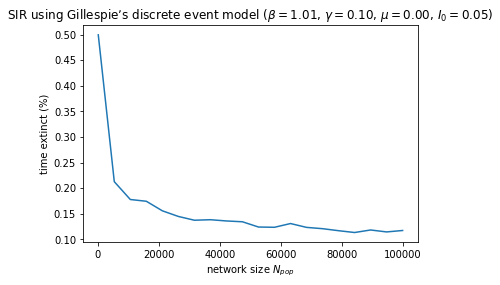

In [407]:
fig, ax = plt.subplots()
ax.plot(network_sizes, time_extinct_per_population_size)
plt.ylabel("time extinct (%)")
plt.xlabel("network size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model (%s)" % config_str(config)
))
plt.show()

In [430]:
# Diseases with a more variable infectious period have greater variability
# in the number of secondary cases, and therefore a greater risk of
# extinction when infectious numbers are low
# critical community size is a persistence measure
# (0.02*np.sqrt(N_pop))/365
import itertools

R_0s = np.linspace(1, 21, 6)
gammas = np.linspace(50, 550, 6)
result = np.zeros((len(R_0s), len(gammas)))
# print(result.shape)

for (ri, R_0), (gi, gamma) in itertools.product(enumerate(R_0s), enumerate(gammas)):
    # print("searching", R_0, gamma)
    for pop_size in np.linspace(0.5, 6, 10):
        mu = 0.02/365
        beta = R_0 * (mu + 1/gamma)
        config = dict(
            beta=beta, gamma=1/gamma, mu=mu, i0=0.05,
            repetitions=1, t_end=5 * 365
        )
        t, results = simulate_sir(
            N_pop=10**pop_size, epsilon=(0.0213*(R_0-1.0)*np.sqrt(N_pop))/365, **config)
        extinctions = results[:,:,1] < 1
        mean_extinctions = extinctions.sum(axis=1).mean()
        time_extinct_per_year = (mean_extinctions / (config["t_end"] / 365))
        # print(time_extinct_per_year)
        if time_extinct_per_year < 2:
            result[ri,gi] = pop_size
            print("found", pop_size, "for", R_0, gamma)
            break
print(result)

found 6.0 for 1.0 50.0
found 2.9444444444444446 for 1.0 150.0
found 2.9444444444444446 for 1.0 250.0
found 2.3333333333333335 for 1.0 350.0
found 1.7222222222222223 for 1.0 450.0
found 2.3333333333333335 for 1.0 550.0
found 3.555555555555556 for 5.0 50.0
found 2.9444444444444446 for 5.0 150.0
found 2.3333333333333335 for 5.0 250.0
found 1.7222222222222223 for 5.0 350.0
found 1.7222222222222223 for 5.0 450.0
found 1.1111111111111112 for 5.0 550.0
found 3.555555555555556 for 9.0 50.0
found 2.9444444444444446 for 9.0 150.0
found 2.3333333333333335 for 9.0 250.0
found 2.3333333333333335 for 9.0 350.0
found 1.7222222222222223 for 9.0 450.0
found 1.7222222222222223 for 9.0 550.0
found 3.555555555555556 for 13.0 50.0
found 2.9444444444444446 for 13.0 150.0
found 2.3333333333333335 for 13.0 250.0
found 2.3333333333333335 for 13.0 350.0
found 1.1111111111111112 for 13.0 450.0
found 1.1111111111111112 for 13.0 550.0
found 3.555555555555556 for 17.0 50.0
found 2.9444444444444446 for 17.0 150.0
fo

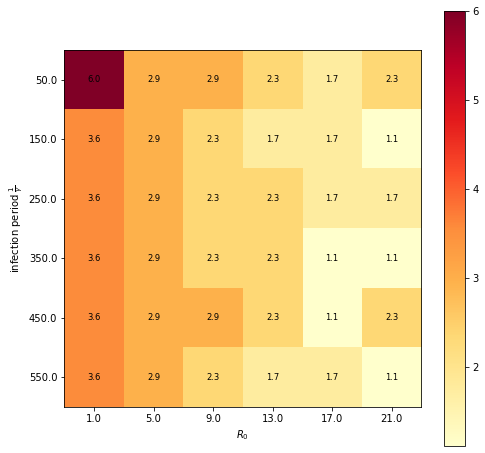

In [454]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(result, cmap='YlOrRd')
x, y = np.arange(result.shape[0]), np.arange(result.shape[1])
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(R_0s)
ax.set_yticklabels(gammas)
plt.ylabel("infection period $\\frac{1}{\gamma}$")
plt.xlabel("$R_0$")
plt.colorbar(im)
for ix in x:
    for iy in y:
        text = ax.text(iy, ix, np.round(result[ix, iy], 1),
                       ha="center", va="center", color="black", fontsize="small")
plt.show()

#### Problem 2: Metapopulations

Lets start with implementing a simple meta-population
model to study the spatial dynamics of a spreading infection. Start with a stochastic
meta-population model with two sub-populations. Consider two large, fully susceptible populations, with $\rho_{ii} = 1$ and $\rho_{ij} < 1$. Assume the populations are of the same
size, and ignore demography. What is the effect of the coupling between the two
populations, are there any delays?
Now produce a meta-population of your own using more sub populations (Hint: Try
using different strength of interaction between populations), and comment on the
dynamics.

In [544]:
class SIR_Metapopulation:
    def __init__(
        self, beta, gamma, p,
        num_metapopulations=2,
        i0s: Union[List[float], float] = 0.05,
        N_pops: Union[List[int], int] = 1000,
    ):
        self.beta = beta
        self.gamma = gamma
        self.p = p
        self.num_metapopulations = num_metapopulations
        self.i0s = (
            [i0s] * self.num_metapopulations
            if not isinstance(i0s, list) else i0s
        )
        self.N_pops = (
            [N_pops] * self.num_metapopulations
            if not isinstance(N_pops, list) else N_pops
        )
        self.N_pop = np.sum(self.N_pops)
        assert len(self.i0s) == self.num_metapopulations
        assert len(self.N_pops) == self.num_metapopulations
    
    def simulate(self, t_end=200):
        t = [0]
        
        I = [[int(i0 * n_pop)] for i0, n_pop in zip(self.i0s, self.N_pops)]
        S = [[n_pop - Ii[0]] for n_pop, Ii in zip(self.N_pops, I)]
        R = [[0] for _ in self.N_pops]
        # print("S", S)
        # print("I", I)
        # print("R", R)
        
        while t[-1] < float(t_end):
            # N = S[-1] + I[-1] + R[-1]
            # N = np.max([0.0001, N]) # avoid zero
            events = dict()
            infected = np.array([
                I[j][-1] for j in range(self.num_metapopulations)
            ])
            for pop in range(self.num_metapopulations):
                # print(infected.shape, self.p[pop].shape)
                transmission = self.beta * S[pop][-1] * np.sum(
                    self.p[pop] * infected
                ) / self.N_pop
                # print(transmission)
                events[(pop, "transmission")] = transmission
                events[(pop, "recovery")] = self.gamma * I[pop][-1]
            
            # events = {
                # "birth": self.mu * N,
                #"transmission": self.beta * S[-1] * I[-1] / N,
                #"recovery": self.gamma * I[-1],
                # "death_susceptible": self.mu * S[-1],
                # "death_infected": self.mu * I[-1],
                # "death_recovered": self.mu * R[-1],
                # "import": self.epsilon * N,
                # "import": self.epsilon * S[-1],
            # }
            events = {event: rate for event, rate in events.items() if rate > 0}
            # pprint(events)
            if len(events) < 1:
                break
            
            for pop in range(self.num_metapopulations):
                S[pop].append(S[pop][-1])
                I[pop].append(I[pop][-1])
                R[pop].append(R[pop][-1])
            
            # compute arrival times for each
            event_time = {
                event: -1.0/rate * np.log(np.random.uniform(0, 1))
                for event, rate in events.items()
            }
            
            # choose event that will occur next
            (pop, event), arrival = sorted(event_time.items(), key=lambda x: x[1])[0]
            
            #if event == "birth":
            #    S[-1] += 1
            if event == "transmission":
                S[pop][-1] -= 1
                I[pop][-1] += 1
            elif event == "recovery":
                I[pop][-1] -= 1
                R[pop][-1] += 1
            # elif event == "death_susceptible":
            #    S[-1] -= 1
            #elif event == "death_infected":
            #    I[-1] -= 1
            #elif event == "death_recovered":
            #    R[-1] -= 1
            #elif event == "import":
            #    S[-1] -= 1
            #    I[-1] += 1
            
            t.append(t[-1] + arrival)
        
        t = np.array(t)
        tt = np.linspace(0, t_end, t_end)
        result = []
        for pop in range(self.num_metapopulations):
            Sip = interp1d(t, np.array(S[pop]), fill_value="extrapolate")
            Iip = interp1d(t, np.array(I[pop]), fill_value="extrapolate")
            Rip = interp1d(t, np.array(R[pop]), fill_value="extrapolate")
            pop_result = np.array([Sip(tt), Iip(tt), Rip(tt)]).T
            result.append(pop_result)
        result = np.array(result)
        return t, tt, result

In [545]:
np.random.seed(42)
p = np.random.uniform(0, 0.99, size=(2,2))
p *= 0.5
np.fill_diagonal(p, 1)
print(p)
config = dict(
    beta=0.05, gamma=0.01,
)
model = SIR_Metapopulation(
    num_metapopulations=2,
    i0s = [0.1, 0.0],
    N_pops = [10_000, 10_000],
    p = p,
    **config,
)
results = []
for _ in range(5):
    _, tt, result = model.simulate(600)
    results.append(result)
results = np.array(results)

[[1.         0.47060358]
 [0.362337   1.        ]]


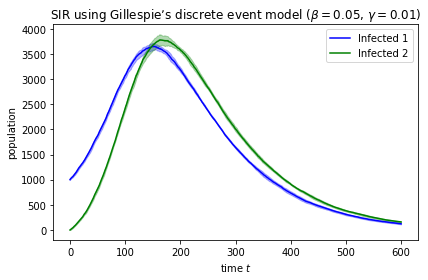

In [550]:
fig, ax = _plot_sir({
    "Infected 1": (tt, results[:,0,:,1], dict(color="blue")),
    "Infected 2": (tt, results[:,1,:,1], dict(color="green")),
}, config=config)
plt.show()

In [566]:
# produce a meta-population of your own using more sub populations (Hint: Try
# using different strength of interaction between populations

# choose 10 populations? with each 10 repetitions

# idea 1: unidirectional
# small interactions
# big interactions
n_metapopulations = 10
interaction_mat_size = (n_metapopulations, n_metapopulations)
top_mask = np.zeros(interaction_mat_size, dtype=bool)
for i,j in itertools.product(range(n_metapopulations), range(n_metapopulations)):
    if i<j:
        top_mask[i,j] = True
print(top_mask)
print(top_mask.T)

[[False  True  True  True  True  True  True  True  True  True]
 [False False  True  True  True  True  True  True  True  True]
 [False False False  True  True  True  True  True  True  True]
 [False False False False  True  True  True  True  True  True]
 [False False False False False  True  True  True  True  True]
 [False False False False False False  True  True  True  True]
 [False False False False False False False  True  True  True]
 [False False False False False False False False  True  True]
 [False False False False False False False False False  True]
 [False False False False False False False False False False]]
[[False False False False False False False False False False]
 [ True False False False False False False False False False]
 [ True  True False False False False False False False False]
 [ True  True  True False False False False False False False]
 [ True  True  True  True False False False False False False]
 [ True  True  True  True  True False False False Fals

high bidirectional interaction


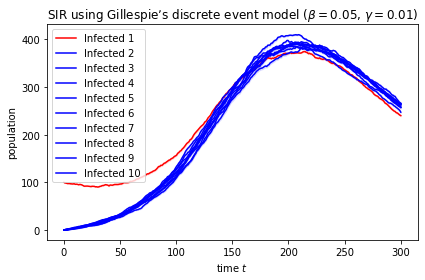

low bidirectional interaction


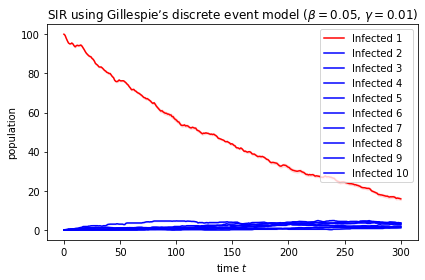

unidirectional 1


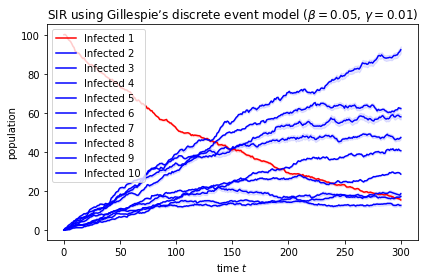

unidirectional 2


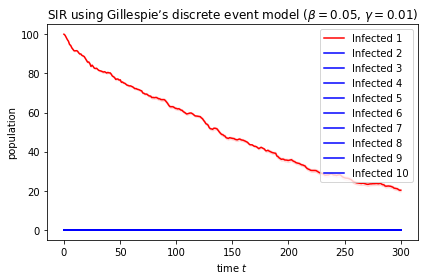

In [575]:
# produce a meta-population of your own using more sub populations (Hint: Try
# using different strength of interaction between populations
unidirectional1 = np.random.uniform(0, 0.9, size=interaction_mat_size)
unidirectional1[top_mask] = 0.0

unidirectional2 = np.random.uniform(0, 0.9, size=interaction_mat_size)
unidirectional2[top_mask.T] = 0.0

np.random.seed(42)
ps = [
    (
        "high bidirectional interaction",
        np.random.uniform(0.5, 0.99, size=interaction_mat_size)
    ),
    (
        "low bidirectional interaction",
        np.random.uniform(0, 0.1, size=interaction_mat_size)
    ),
    (
        "unidirectional 1", unidirectional1
    ),
    (
        "unidirectional 2", unidirectional2
    ),
]
for desc, p in ps:
    np.fill_diagonal(p, 1)
    print(desc)
    config = dict(
        beta=0.05, gamma=0.01,
    )
    model = SIR_Metapopulation(
        num_metapopulations=n_metapopulations,
        i0s = [0.1] + ([0.0] * (n_metapopulations - 1)),
        N_pops = [1_000] * n_metapopulations,
        p = p,
        **config,
    )
    results = []
    for _ in range(5):
        _, tt, result = model.simulate(300)
        results.append(result)
    results = np.array(results)
    
    fig, ax = _plot_sir({
        f"Infected {pop+1}": (
            tt, results[:,pop,:,1], dict(color="red" if pop == 0 else "blue")
        ) for pop in range(n_metapopulations)
    }, config=config, confidence_scale=0.1, confidence_alpha=0.1)
    plt.show()

#### Network model and Vaccines
In this question you are asked to develop a set
of experiments to design and evaluate vaccination strategies using a network model.
Using the package NDLib1 you should assess the spread of a disease (SIR) across different
types of networks (Barabasi Albert, Watts-Strogatz, Erdos-Reyni).

How to assess the impact/spread of the epidemic (what to measure)

In [ ]:
class SIR_Network:
    def __init__(
        self,
        beta = 0.001,
        gamma = 0.01,
    ):
        self.beta = beta
        self.gamma = gamma
    
    def simulate(
        self,
        graph,
        infected: Union[List[int], float] = 0.05,
        iterations: int = 200
    ):
        config = mc.Configuration()
        config.add_model_parameter('beta', self.beta)
        config.add_model_parameter('gamma', self.gamma)
        if isinstance(self.infected, list):
            config.add_model_initial_configuration("Infected", self.infected)
        else:
            config.add_model_parameter("fraction_infected", self.infected)
        
        # model = ep.SIRModel(graph)
        model = gc.CompositeModel(graph)

        # Model statuses
        sir_demo.add_status("Susceptible")
        sir_demo.add_status("Infected")
        sir_demo.add_status("Recovered")
        # sir_demo.add_status("Dead")
        # sir_demo.add_status("Unborn")

        # Compartment definition
        imports = ns.NodeStochastic(0.01, triggering_status="Infected")
        deaths = 
        s_to_i = ns.NodeStochastic(0.02, triggering_status="Infected")
        i_to_r = ns.NodeStochastic(0.01) # 

        # Rule definition
        sir_demo.add_rule("Susceptible", "Infected", s_to_i)
        sir_demo.add_rule("Susceptible", "Infected", s_to_i)
        sir_demo.add_rule("Susceptible", "Infected", s_to_i)
        sir_demo.add_rule("Infected", "Removed", i_to_r)
        
        model.set_initial_status(config)
        
        # simulate
        simulations = model.iteration_bunch(iterations)
        compartments = list(model.available_statuses.values())
        results = np.zeros((len(simulations), len(compartments)))
        for it in simulations:
            for compartment, node_count in it["node_count"].items():
                results[it["iteration"], compartment] = node_count
        return results
        

def simulate_sir_ndlib(beta=0.001, gamma=0.01, i0=0.05, network_size=1000, edge_prob=0.1, iterations=200):
    # build a network
    
    # parameterize
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", i0)
    
    model = ep.SIRModel(g)
    model.set_initial_status(config)
    
    # simulate
    simulations = model.iteration_bunch(iterations)
    trends = model.build_trends(simulations)
    
    # build results
    compartments = list(model.available_statuses.values())
    results = np.zeros((len(simulations), len(compartments)))
    for it in simulations:
        for compartment, node_count in it["node_count"].items():
            results[it["iteration"], compartment] = node_count
    
    # visualize
    viz = DiffusionTrend(model, trends)
    return (model, g), (results, simulations, trends), viz

How to vary disease initalisation - how many and which nodes to start the
infection with?

- we have a frac infected. but we could also do it manually, either starting the infections from random nodes or from ones that are connected to each other

In [ ]:
g = nx.erdos_renyi_graph(n=network_size, p=edge_prob) # create new edge with prob p
g = nx.barabasi_albert_graph(n=network_size, m=edge_prob) # connect to m random nodes
g = nx.watts_strogatz_graph(n=network_size, k=edge_prob) # connect to k neighbours

In [ ]:
infected_nodes = [0, 1, 2, 3, 4, 5]
config.add_model_initial_configuration("Infected", infected_nodes)